# Bike Sharing Analysis

## Table of contents

1. Introduction
2. Import libraries, load and transform data
3. A look into the data
4. Prediction model and interpretation
5. Prediction function for daily usage
6. Results

## 1. Introduction

Bike sharing companies are on the rise since years and are very popular in the metropolitan areas around the world. Reliability, availability and user-friendly processes are important aspects of the business. To provide constant quality and availabilty to the customer it is crucial to understand the significant factors of demand. Since every bike needs maintenance from time to time you better know when you can spare some of your capacity and when it is highly demanded. 

The following notebook provides: 
- a general analysis of the Bike Sharing Dataset from this website: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- a prediction model for the utilization of bikes per hour with insights about the factors and main effects
- an operative function to predict the utilization for future days.

With the help of the tool provided, managers are able to plan their maintenance phases and investments more efficiently. 

The problem with regression models which estimate mean values is that approximately half of all cases you will be above the estimates.
To provide a high level of availability and reliability for the customer it is benificial to use upper bounds of estimated utilization hence the chosen regression method is a quantile regression model.
This product allows the company to prepare for upcoming demands with respect to a desired level of reliability (e.g. 90%).

It will turn out that the most significant effect comes from customers using bikes in the morning and afterwork hours on workdays. It is recommended to plan with respect to these critical moments to obtain a high level of customer satisfaction.
Ending up with no bike in the morning hours can put customers into difficult situations with a high risk of bad reputation for the company - a good ground for competitors.

## 2. Import libraries, load and transform data

In [1]:
import numpy as np
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import mlab
import datetime

#### The data and attribute info from the website
Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
 1. Clear, Few clouds, Partly cloudy, Partly cloudy
 2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [2]:
day = pd.read_csv("day.csv", sep = ',')
hour = pd.read_csv("hour.csv", sep = ',')
day['dteday'] = pd.to_datetime(day['dteday'])
hour['dteday'] = pd.to_datetime(hour['dteday'])
hour['timestamp'] = pd.to_datetime(hour['dteday']) + hour['hr'].astype('timedelta64[h]')
hour['time'] = hour['dteday'] - hour['dteday'].min() # prepare timestamp and count days for prediction
hour['days'] = hour['time'].dt.days 

## 3. A look into the data

### First thoughts
The dataset contains no missing values, appears to be very clean, has standardized measures and no obvious outliers.
I had no doubt that it is a ready to use data set.

Let us have a look at the time series of the utilization ('cnt' variable) per day and per hour.


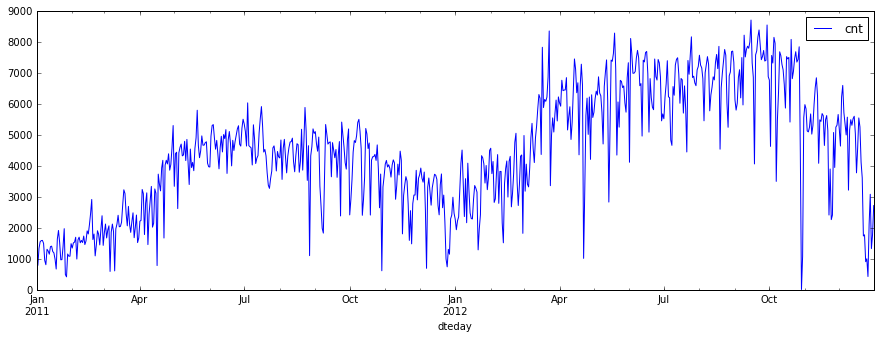

In [3]:
count_by_day = day[['dteday','cnt']].set_index('dteday')
plt.figure()
count_by_day.plot(figsize=(15,5))
plt.legend(loc='best')

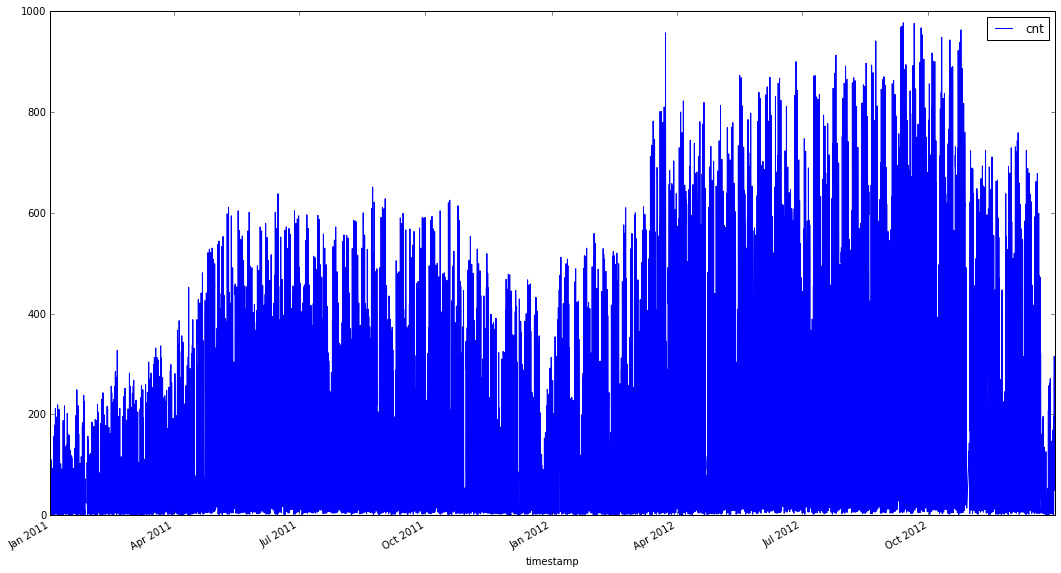

In [4]:
count_by_hour = hour[['timestamp','cnt']].set_index('timestamp')
plt.figure()
count_by_hour.plot(figsize=(18,10))
plt.legend(loc='best')

#### Thoughts on the time series
Both resolutions of the utilization time series show similar behaviour.
There is periodicity over the year. In summer time more bikes are used than in winter time. It is an increasing and then decreasing progress. Very important here is that the level of Jan 2011 is almost the same as in Dec 2011, Jan 2012 and Dec 2012. The plateau during summer 2012 is higher than in 2011. I conclude that there might have been an investment in beginning of 2012 and the capacity has been scaled up by a certain factor. I would rather not speak of a significant increasing trend over time, and the linear models I tried did not show a high regression coefficient for the time aspect. 
So let us further assume that changes of the system like investments explain the difference between time periods. Since there is no information in the data about the total amount of bikes available we can only speculate about this. The absolute maximum values per year could give us some estimate which supports the theory. 
All changes of the system should be taken into account when forecasting and should be tracked by (categorical) indicators in the data to estimate a proper mean for the new time period.

#### The top 20 days 
1. All top 20 days are from year 2012
2. Top days can occur in every season but half of the top 20 days are from autumn.
3. No holiday is under the top 20 days.
4. Top days can be working days and not.
5. Top 20 days are never with bad weather conditions.

In [5]:
day.sort_values(by = ['cnt'], ascending = False).head(20)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
623,624,2012-09-15,3,1,9,0,6,0,1,0.608333,0.585867,0.501667,0.247521,3160,5554,8714
637,638,2012-09-29,4,1,9,0,6,0,1,0.542500,0.530296,0.542917,0.227604,2589,5966,8555
630,631,2012-09-22,3,1,9,0,6,0,1,0.650000,0.610488,0.646667,0.283583,2512,5883,8395
447,448,2012-03-23,2,1,3,0,5,1,2,0.601667,0.570067,0.694167,0.116300,2469,5893,8362
504,505,2012-05-19,2,1,5,0,6,0,1,0.600000,0.566908,0.456250,0.083975,3410,4884,8294
617,618,2012-09-09,3,1,9,0,0,0,1,0.610000,0.578925,0.547500,0.224496,2570,5657,8227
571,572,2012-07-25,3,1,7,0,3,1,1,0.724167,0.654054,0.450000,0.164800,1383,6790,8173
629,630,2012-09-21,3,1,9,0,5,1,1,0.599167,0.571971,0.668750,0.154229,1250,6917,8167
643,644,2012-10-05,4,1,10,0,5,1,1,0.615000,0.580187,0.627500,0.106350,1516,6640,8156
518,519,2012-06-02,2,1,6,0,6,0,1,0.583333,0.566288,0.549167,0.186562,2795,5325,8120


### Lets consider the distribution of utilization (per day and per hour) over the years and some categorical variables.

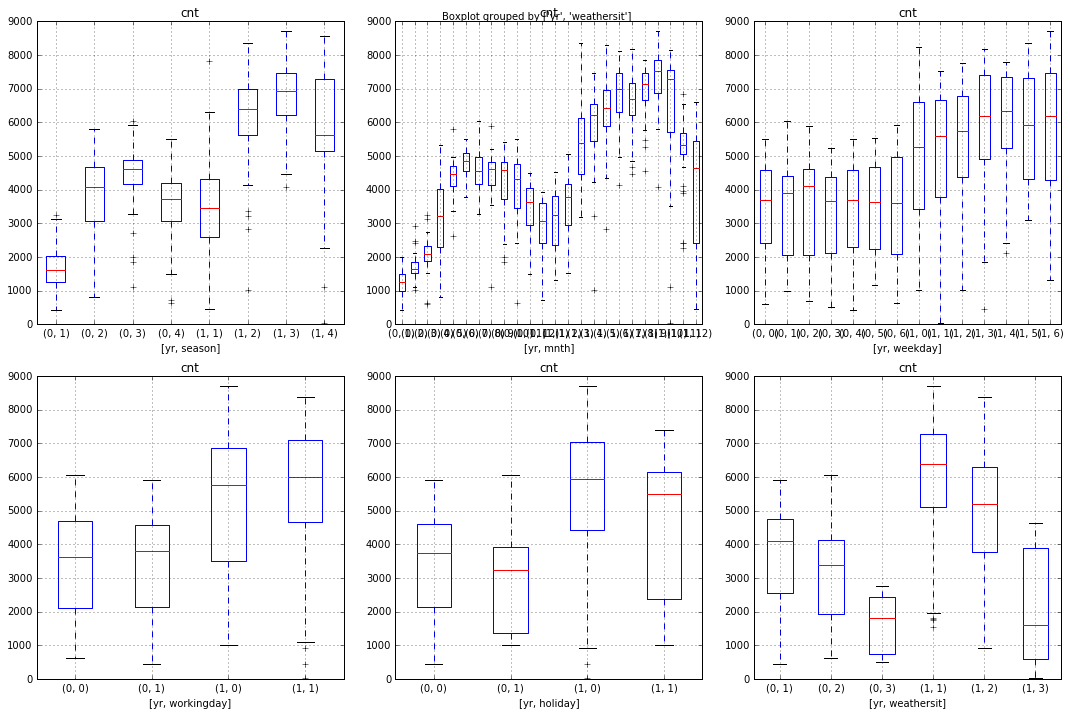

In [6]:
fig, axes = plt.subplots(2,3, figsize=(15,10)) # create figure and axes


day.boxplot(column='cnt',by=['yr','season'], ax=axes.flatten()[0] )

day.boxplot(column='cnt',by=['yr','mnth'], ax=axes.flatten()[1])

day.boxplot(column='cnt',by=['yr','weekday'], ax=axes.flatten()[2])

day.boxplot(column='cnt',by=['yr','workingday'], ax=axes.flatten()[3])

day.boxplot(column='cnt',by=['yr','holiday'], ax=axes.flatten()[4])

day.boxplot(column='cnt',by=['yr','weathersit'], ax=axes.flatten()[5])

#fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout() 

plt.show()

#### thoughts

Boxplots from left to right row-wise:

1. spring is the season with the lowest daily counts for each year and summer is the highest. The relations between the seasons is alike for both years.

2. The month seems to give a better information than the season. (This graph looks like there is a positive trend over time, but the linear models did not confirm it)
3. The days of the week could play a role, especially in year 2012. But it is not strong.
4. Workingday information is weak with respect of daily total utilization.
5. Holidays tend to have a slightly lower daily utilization compared to non-holidays.
6. The worse the weather situation the lower the daily utilization. 



#### Next step: Have a look at the data per hour and focus on the year 2012 only since the overall behaviour is very similar.

#### Top 20 hours
1. All of them are form 2012
2. Season is most likely autumn or early winter
3. Top 20 hours are always on working days with good weather conditions during early after work.

In [7]:
hour.sort_values(by = ['cnt'], ascending = False).head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,timestamp,time,days
14773,14774,2012-09-12,3,1,9,18,0,3,1,1,0.66,0.6212,0.44,0.2537,91,886,977,2012-09-12 18:00:00,620 days,620
14964,14965,2012-09-20,3,1,9,17,0,4,1,1,0.64,0.6212,0.50,0.2239,91,885,976,2012-09-20 17:00:00,628 days,628
14748,14749,2012-09-11,3,1,9,17,0,2,1,1,0.70,0.6364,0.28,0.0000,168,802,970,2012-09-11 17:00:00,619 days,619
14725,14726,2012-09-10,3,1,9,18,0,1,1,1,0.62,0.6212,0.35,0.2985,111,857,968,2012-09-10 18:00:00,618 days,618
15084,15085,2012-09-25,4,1,9,17,0,2,1,1,0.66,0.6212,0.39,0.2836,107,860,967,2012-09-25 17:00:00,633 days,633
15780,15781,2012-10-24,4,1,10,17,0,3,1,1,0.66,0.6212,0.47,0.0000,87,876,963,2012-10-24 17:00:00,662 days,662
10622,10623,2012-03-23,2,1,3,17,0,5,1,2,0.72,0.6515,0.42,0.1642,264,693,957,2012-03-23 17:00:00,447 days,447
15108,15109,2012-09-26,4,1,9,17,0,3,1,1,0.74,0.6667,0.48,0.2985,77,876,953,2012-09-26 17:00:00,634 days,634
15444,15445,2012-10-10,4,1,10,17,0,3,1,1,0.58,0.5455,0.43,0.2239,91,857,948,2012-10-10 17:00:00,648 days,648
15588,15589,2012-10-16,4,1,10,17,0,2,1,1,0.52,0.5000,0.39,0.1940,104,839,943,2012-10-16 17:00:00,654 days,654


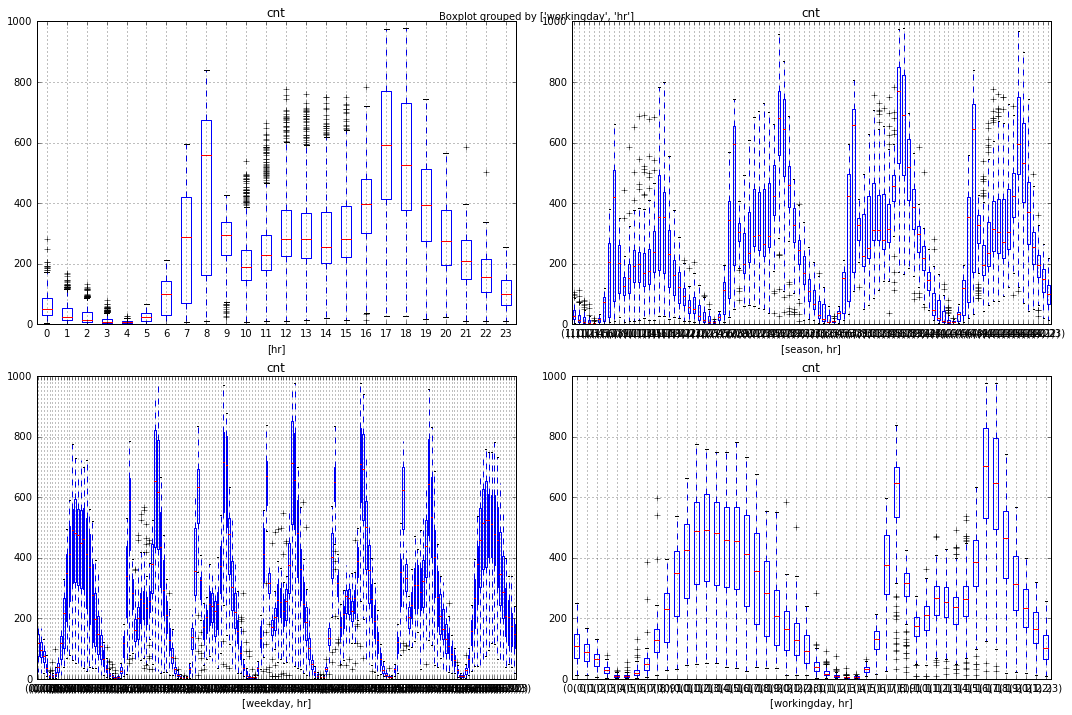

In [8]:
fig, axes = plt.subplots(2,2, figsize=(15,10)) # create figure and axes


hour[hour['yr']==1].boxplot(column='cnt',by=['hr'], ax=axes.flatten()[0])

hour[hour['yr']==1].boxplot(column='cnt',by=['season','hr'], ax=axes.flatten()[1])

hour[hour['yr']==1].boxplot(column='cnt',by=['weekday','hr'], ax=axes.flatten()[2])

hour[hour['yr']==1].boxplot(column='cnt',by=['workingday','hr'], ax=axes.flatten()[3])

#hour.boxplot(column='cnt',by=['yr','holiday'], ax=axes.flatten()[4])

#hour.boxplot(column='cnt',by=['yr','weathersit'], ax=axes.flatten()[5])

#fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout() 

plt.show()

#### thoughts

Boxplots from left to right row-wise:

1. Morning and afternoon hours have significant peaks over the day. Night and afternoon hours have an interesting ammount of outliers.

2. The peaks remain for every season of the year. This is a characteristic profile.
3. The weekday has some impact on the hourly profile. On Saturdays and Sundays people use bikes around noon. This also explains the outliers in the first figure. Eureka!
4. The comparison of working days and non-working days is consistent with the former observations and supports the theory that people tend to use bikes more frequently at noon and in the late night on free days.

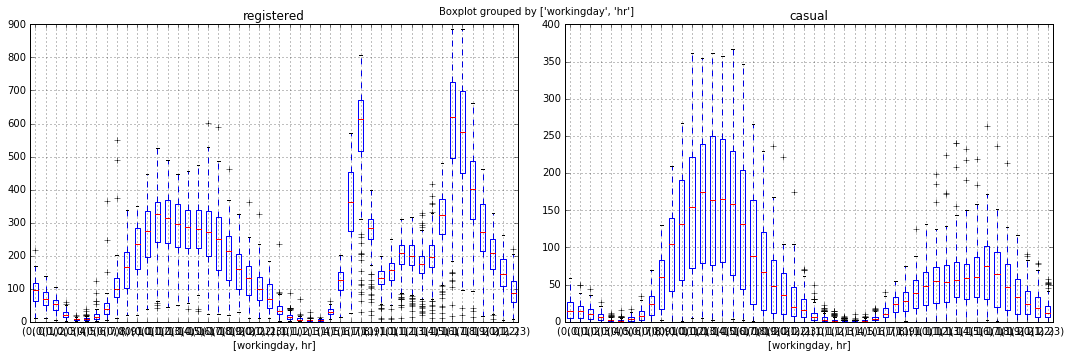

In [12]:
# Split utilization into regsitered and casual users

fig, axes = plt.subplots(1,2 , figsize=(15,5)) # create figure and axes

hour[hour['yr']==1].boxplot(column='registered',by=['workingday','hr'] , figsize=(7,5), ax=axes.flatten()[0])

hour[hour['yr']==1].boxplot(column='casual',by=['workingday','hr'] , figsize=(7,5), ax=axes.flatten()[1] )


#fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout() 

plt.show()

#### conclusions

On workingdays people use bikes to get to and from work where on weekends (and holidays) people use them more during noon and late night hours. Other factors like weather and time of the year affect the baseline of the utilization since a proportion of people might avoid biking in winter and bad weather in general. 


#### Now let us have a look at the remeining variables and their pairwise relation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129f76ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12df1e400>]], dtype=object)

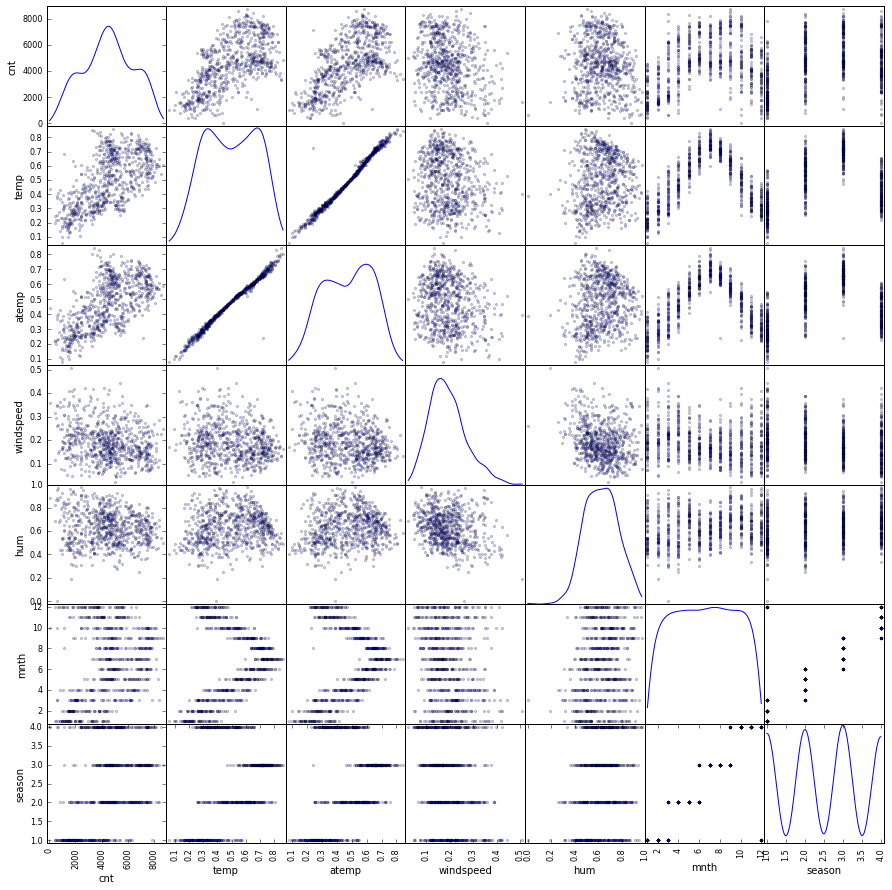

In [9]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(day[['cnt','temp','atemp','windspeed','hum','mnth','season']],
               alpha=0.2, figsize=(15, 15), diagonal='kde')

#### Discussion of the plots above
Some variables are redundant: 

1. If you know which month you are then you exactly know which season it is, you have a good idea about the temperature, you know nothing about windspeed or humidity but it has some impact on the utilization.

2. There is also a high correlation between the temperature and the felt-temperature, so you definetly need only one of them. Since the temperature is easier to get from weather apps, we drop the 'atmep' variable.

3. To make it short: The linear OLS regression showed evidence of multicollinearity when combining the mentioned variables into one model and in the end the simplest predictos already gave you a good model fit. Using more precise information only had marginal effect on explaining the response. Hence the following model will only respect the most significant variables.

## 4. Prediction model and interpretation

#### The choice of a model

- After peeking into the data I first tryed a linear OLS regression on the daily dataset and was surprised by the high value of R-squared which was around 0.96 . Since the model had evidence of multicollinearity I removed predictors obviously being redundant as seen in the former section.
- The OLS model based on the daily data had a lower R-squared so at this point I had to decide whether I try to tune it with the help of different machine learning techniques or rather find a good business need first and then make use out of the linear regression. 
- A further observation of the effects in the linear OLS model convinced me to keep it simple since the most significant factors were easy to understand and easy to provide as data in terms of forecasting. (e.g. it is more likely to predict the weathersituation for the next week instead of the correct weather parameters as temperature, humidity and windspeed) Further a parametric model is easy to interpret and gives you quantified results which directly lead to business insights.
- From my own experience with bike sharing products I concluded that a quantile regression might finally be a worthy tool to fulfill customer needs and help planers provide high availability standards on the market.

A lot of different combinations of the predictors have been considered and this is somehow the best compromise I found in terms of R-squared and multicollinearity. Especially the presence of the number of days from 2011-01-01 had very little contribution to R-squared and lead to multicollinearity within the predictors. 
The combination of workingday and hr has good explanation and is adjusted by mnth for high peaks during main season.
I find the following model very easy to interpret and beneficial for a business case. 
The "formula" representation in the statsmodels module makes it very easy to work with models and categorical data.



In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='cnt ~ C(hr) + C(yr) + C(mnth) + C(workingday) + C(weathersit) + C(mnth):C(workingday):C(hr)', data=hour)

OLS_model = mod.fit()
hour['cnt_OLS'] = OLS_model.predict(hour) # writing the predicted values into the dataset

print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     163.0
Date:                Fri, 28 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:50:42   Log-Likelihood:                -98622.
No. Observations:               17379   AIC:                         1.984e+05
Df Residuals:                   16799   BIC:                         2.029e+05
Df Model:                         579                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------

#### The final model

In [13]:
desired_reliability = 0.5

from statsmodels.regression.quantile_regression import QuantReg
qr = QuantReg.from_formula(formula='cnt ~ C(hr) + C(yr) + C(mnth) + C(workingday) + C(weathersit) + C(mnth):C(workingday):C(hr)', data=hour)
q50 = qr.fit(q = desired_reliability)
hour['cnt_q50'] = q50.predict(hour)

//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", Conve

In [14]:
desired_reliability = 0.9

qr = QuantReg.from_formula(formula='cnt ~ C(hr) + C(yr) + C(mnth) + C(workingday) + C(weathersit) + C(mnth):C(workingday):C(hr)', data=hour)
q90 = qr.fit(q = desired_reliability)
hour['cnt_q90'] = q90.predict(hour)

//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", Conve

### Compare the different predictions to the original values of July 2012

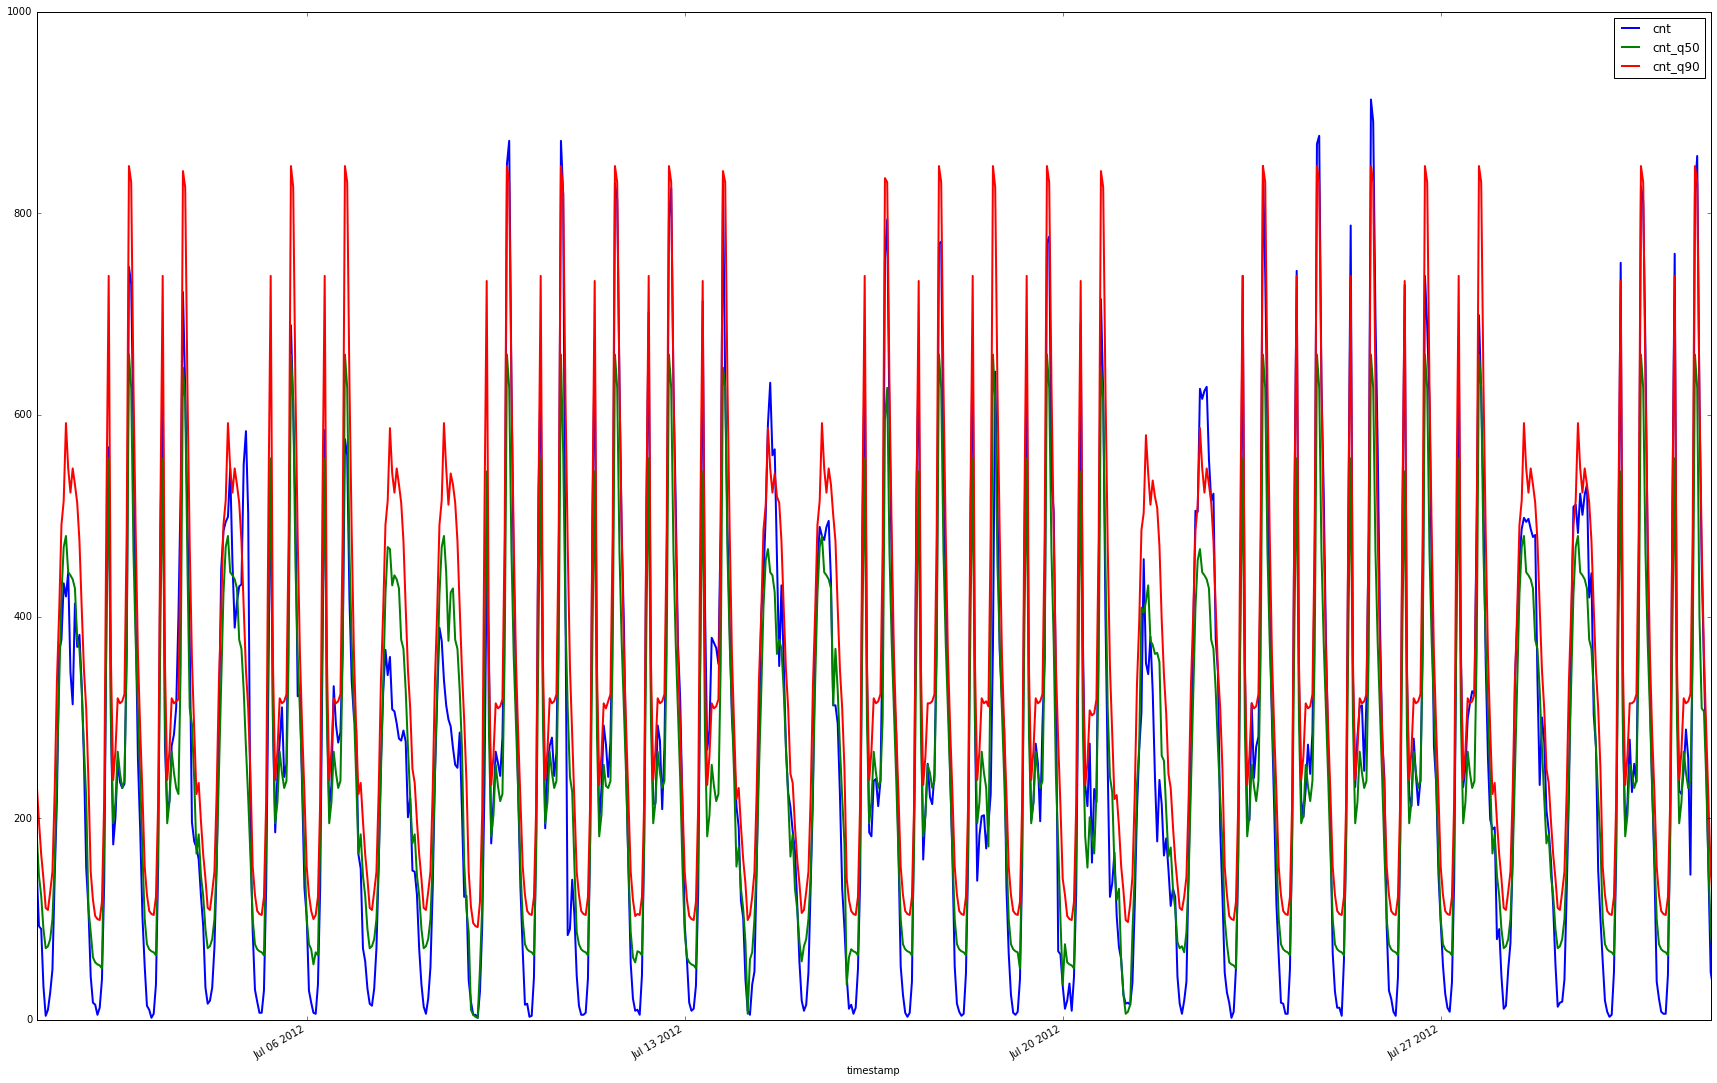

In [15]:
count_by_hour = hour[['timestamp','cnt','cnt_q50','cnt_q90']].set_index('timestamp')

plt.figure( )
count_by_hour.plot(figsize=(30,20), linewidth=2)
plt.xlim(datetime.date(2012, 7, 1), datetime.date(2012, 8, 1))
plt.ylim(0,1000)

plt.legend(loc='best')
plt.show()

#### Discussion
With the predictions of the q90-model only a few hours would have lead to shortage issues. 

Now consider the mean absolute deviance of the predictions from the observed values.

In [16]:
hour['abs_dev_OLS'] = np.abs(hour['cnt']-hour['cnt_OLS'])
hour['abs_dev_q50'] = np.abs(hour['cnt']-hour['cnt_q50'])
hour['abs_dev_q90'] = np.abs(hour['cnt']-hour['cnt_q90'])
print("mean absolute deviance for q50:" , hour['abs_dev_q50'].mean() , "for q90: ", hour['abs_dev_q90'].mean(), "and for OLS:", hour['abs_dev_OLS'].mean() )

mean absolute deviance for q50: 48.68053411650068 for q90:  79.64946908131675 and for OLS: 51.09465833840732


In [17]:
q50.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    cnt   Pseudo R-squared:               0.6462
Model:                       QuantReg   Bandwidth:                       8.994
Method:                 Least Squares   Sparsity:                        83.35
Date:                Fri, 28 Sep 2018   No. Observations:                17379
Time:                        12:28:41   Df Residuals:                    16799
                                        Df Model:                          579
==============================================================================================================
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------
Intercept                                     23.9999      8.892      2.699      0.007         6.571    41.429
C(hr)[T.1]                                    -8.0359     12.616     -0.637      0.524       -32.764    16.692
C(hr)[T.2]                                   -12.9999     12.567     -1.034      0.301       -37.632    11.632
C(hr)[T.3]                                   -18.9999     12.715     -1.494      0.135       -43.923     5.923
C(hr)[T.4]                                   -22.9999     12.715     -1.809      0.070       -47.923     1.924
C(hr)[T.5]                                   -22.9999     13.054     -1.762      0.078       -48.587     2.587
C(hr)[T.6]                                   -22.9999     12.716     -1.809      0.071       -47.925     1.925
C(hr)[T.7]                                   -21.8982     12.566     -1.743      0.081       -46.529     2.733
C(hr)[T.8]                                    -9.8099     12.566     -0.781      0.435       -34.441    14.821
C(hr)[T.9]                                     8.6222     12.566      0.686      0.493       -16.008    33.253
C(hr)[T.10]                                   45.5594     12.567      3.625      0.000        20.927    70.192
C(hr)[T.11]                                   68.9986     12.566      5.491      0.000        44.367    93.630
C(hr)[T.12]                                   90.4502     12.567      7.198      0.000        65.818   115.082
C(hr)[T.13]                                   83.1195     12.567      6.614      0.000        58.488   107.751
C(hr)[T.14]                                   94.0584     12.566      7.485      0.000        69.428   118.689
C(hr)[T.15]                                   99.2239     12.566      7.896      0.000        74.593   123.855
C(hr)[T.16]                                   90.4161     12.567      7.195      0.000        65.784   115.048
C(hr)[T.17]                                   55.0003     12.566      4.377      0.000        30.369    79.631
C(hr)[T.18]                                   51.7992     12.566      4.122      0.000        27.168    76.431
C(hr)[T.19]                                   36.9972     12.567      2.944      0.003        12.365    61.630
C(hr)[T.20]                                   20.9193     12.566      1.665      0.096        -3.712    45.550
C(hr)[T.21]                                    5.5882     12.566      0.445      0.657       -19.043    30.219
C(hr)[T.22]                                   -4.5165     12.567     -0.359      0.719       -29.149    20.116
C(hr)[T.23]                                   -3.9998     12.566     -0.318      0.750       -28.631    20.631
C(yr)[T.1]                                    65.0000      0.633    102.642      0.000        63.759    66.241
C(mnth)[T.2]                                  -2.6280     13.246     -0.198      0.843       -28.592    23.336
C(mnth)[T.3]                                  14.0001     13.461      1.040      0.298       -12.384 

In [18]:
q90.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    cnt   Pseudo R-squared:               0.7556
Model:                       QuantReg   Bandwidth:                       10.04
Method:                 Least Squares   Sparsity:                        101.6
Date:                Fri, 28 Sep 2018   No. Observations:                17379
Time:                        12:28:41   Df Residuals:                    16799
                                        Df Model:                          579
==============================================================================================================
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------
Intercept                                     30.0000      7.487      4.007      0.000        15.325    44.675
C(hr)[T.1]                                    -1.0000     10.180     -0.098      0.922       -20.953    18.953
C(hr)[T.2]                                   -12.0000     10.573     -1.135      0.256       -32.725     8.725
C(hr)[T.3]                                   -17.0000      9.913     -1.715      0.086       -36.431     2.431
C(hr)[T.4]                                   -22.0000      9.910     -2.220      0.026       -41.424    -2.576
C(hr)[T.5]                                   -22.0000     10.346     -2.126      0.033       -42.279    -1.721
C(hr)[T.6]                                   -23.0000      9.912     -2.320      0.020       -42.428    -3.572
C(hr)[T.7]                                   -20.0000     10.571     -1.892      0.059       -40.721     0.721
C(hr)[T.8]                                    -3.0000      9.732     -0.308      0.758       -22.075    16.075
C(hr)[T.9]                                    13.0000     10.571      1.230      0.219        -7.721    33.721
C(hr)[T.10]                                   66.0000      9.736      6.779      0.000        46.916    85.084
C(hr)[T.11]                                  131.0000     10.574     12.388      0.000       110.273   151.727
C(hr)[T.12]                                  189.0000     10.576     17.871      0.000       168.271   209.729
C(hr)[T.13]                                  218.0000     10.576     20.614      0.000       197.271   238.729
C(hr)[T.14]                                  203.0000     10.573     19.200      0.000       182.276   223.724
C(hr)[T.15]                                  205.0000     10.573     19.389      0.000       184.276   225.724
C(hr)[T.16]                                  197.0000     10.573     18.632      0.000       176.275   217.725
C(hr)[T.17]                                  109.0000     10.573     10.309      0.000        88.276   129.724
C(hr)[T.18]                                   67.0000     10.573      6.337      0.000        46.276    87.724
C(hr)[T.19]                                   49.0000     10.573      4.634      0.000        28.275    69.725
C(hr)[T.20]                                   16.0000      9.733      1.644      0.100        -3.078    35.078
C(hr)[T.21]                                    9.0000     10.573      0.851      0.395       -11.723    29.723
C(hr)[T.22]                                    2.0000     10.574      0.189      0.850       -18.727    22.727
C(hr)[T.23]                                    3.0000      9.732      0.308      0.758       -16.075    22.075
C(yr)[T.1]                                    95.0000      0.484    196.286      0.000        94.051    95.949
C(mnth)[T.2]                                  12.0000     10.609      1.131      0.258        -8.795    32.795
C(mnth)[T.3]                                  31.0000     10.917      2.840      0.005         9.602 

## 5. Prediction function for daily usage

In [19]:
class utilization_prediction:
    
    def __init__(self, data):
        self.data = data
        
        import pandas as pd
        import numpy as np
        from statsmodels.regression.quantile_regression import QuantReg
    
    # can be called once a day to learn model on given data
    def fit_model(self, desired_reliability):
        qr = QuantReg.from_formula(formula='cnt ~ C(hr) + C(yr) + C(mnth) + C(workingday) + C(weathersit) + C(mnth):C(workingday):C(hr) ', data=self.data)
        self.qr_model = qr.fit(q = desired_reliability)
        #qr = smf.ols(formula='cnt ~ C(hr) + C(yr) + C(mnth) + C(workingday) + C(weathersit) + C(mnth):C(workingday):C(hr) ', data=self.data)
        #self.qr_model = qr.fit()
    
    # can be called multiple times a day to produce a prediction of a specific scenario
    def prediction(self,yr,mnth,workingday,weathersit):
        
        col_names =  ['hr','yr','mnth','workingday','weathersit']
        X  = pd.DataFrame( columns = col_names)
        
        hours = range(0,24)
        
        for hour in hours:
            X = X.append(pd.DataFrame([[hour,yr,mnth,workingday,weathersit]], columns = col_names))
        
        results = self.qr_model.predict(X)
            
        return(results)
      
        
    
    
    

In [20]:
#define model
model = utilization_prediction(hour)

In [21]:
# fit model for specific confidence level
model.fit_model(desired_reliability=0.9)

//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", Conve

In [22]:
# predict utilization per hour for given attributes
model.prediction(yr=1,mnth=9,workingday=0,weathersit=1)

array([ 207.01685883,  183.00547201,  176.00336414,  138.00000859,
        104.00000355,  106.98114753,  117.99999937,  139.00004075,
        218.00044648,  342.00454898,  489.00039153,  626.00289637,
        706.00063622,  704.00528977,  666.0125366 ,  696.00036021,
        701.0093322 ,  712.0163873 ,  594.00534896,  470.00366992,
        338.00110268,  302.00626652,  270.00834781,  231.00080933])

In [23]:
# predict utilization per hour for given attributes
model.prediction(yr=1,mnth=9,workingday=1,weathersit=1)

array([ 143.00002188,  120.99999907,  112.99999873,  108.99999915,
        108.0000097 ,  127.99999916,  217.00002042,  556.00021502,
        790.00232596,  361.00104913,  240.00560627,  296.00012162,
        354.00657189,  366.00860653,  366.00787315,  352.00292535,
        509.00011482,  925.00381272,  892.00301662,  627.00208363,
        434.00486594,  320.00001105,  279.00233103,  221.01075313])

## 6. Results

People use bike sharing products all over the year and characteristics can be explained by daily habits and the weather. 

The most significant effect on the utilization can be measured during workingdays. Most people obviously use bikes to get to and from work. This conclusion is supported when comparing the utilization of registered against casual users.
At this point a reliable service is crucial for the customer. People regsiter and rely on the service and should be respected by the company with high standards.

Since the time windows of low utilization are relatively short in the main seasons it helps taking the weather into account when planing any actions to the system like bike maintenance, software updates or investments in general.




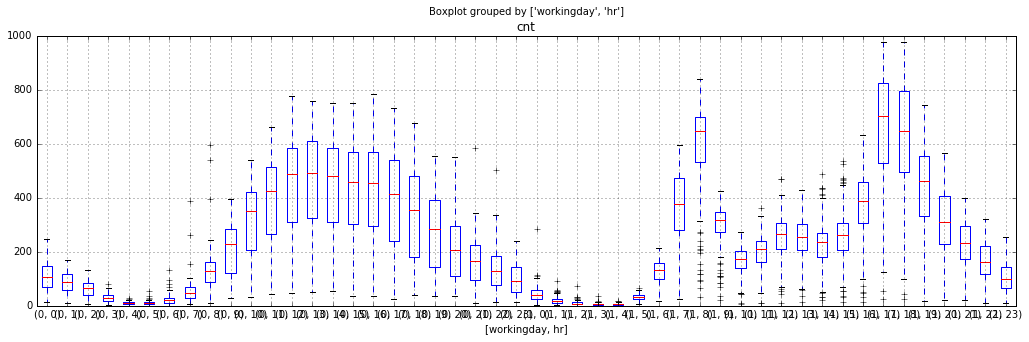

In [24]:
hour[hour['yr']==1].boxplot(column='cnt',by=['workingday','hr'] , figsize=(17,5) )

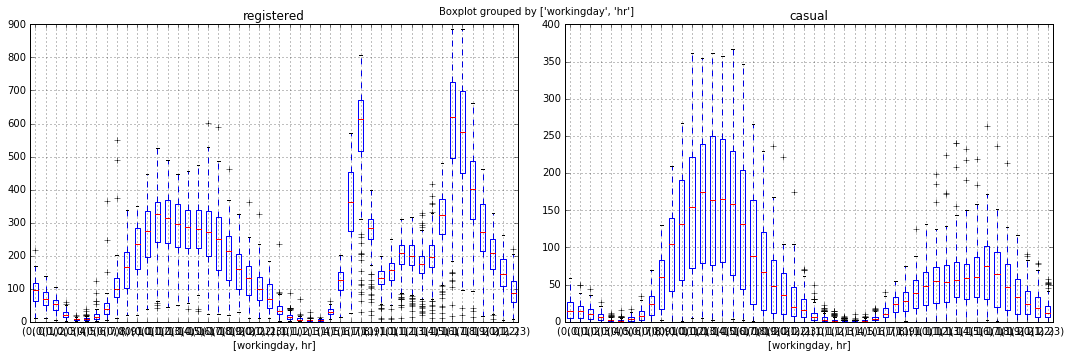

In [25]:
fig, axes = plt.subplots(1,2 , figsize=(15,5)) # create figure and axes

hour[hour['yr']==1].boxplot(column='registered',by=['workingday','hr'] , figsize=(7,5), ax=axes.flatten()[0])

hour[hour['yr']==1].boxplot(column='casual',by=['workingday','hr'] , figsize=(7,5), ax=axes.flatten()[1] )


#fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout() 

plt.show()


On workingdays between afterwork and the next morning lies 10~12 hours of low utilization time. It is highly recommended to set up an agile and quick maintenance routine that frequently repairs bikes and sustains a constant availabilty. With the help of weather prediction it is possible to prepare for high levels of demand during the main season. If you want to assure high availabilty standards you can use the quantile regression with a high level of confidence and prepare for most of the upcoming rush hours. 
The next figure shows utilization and predicted utilization during one week of July 2012.
You can easily spot the characteristic curve for weekend and workingdays.

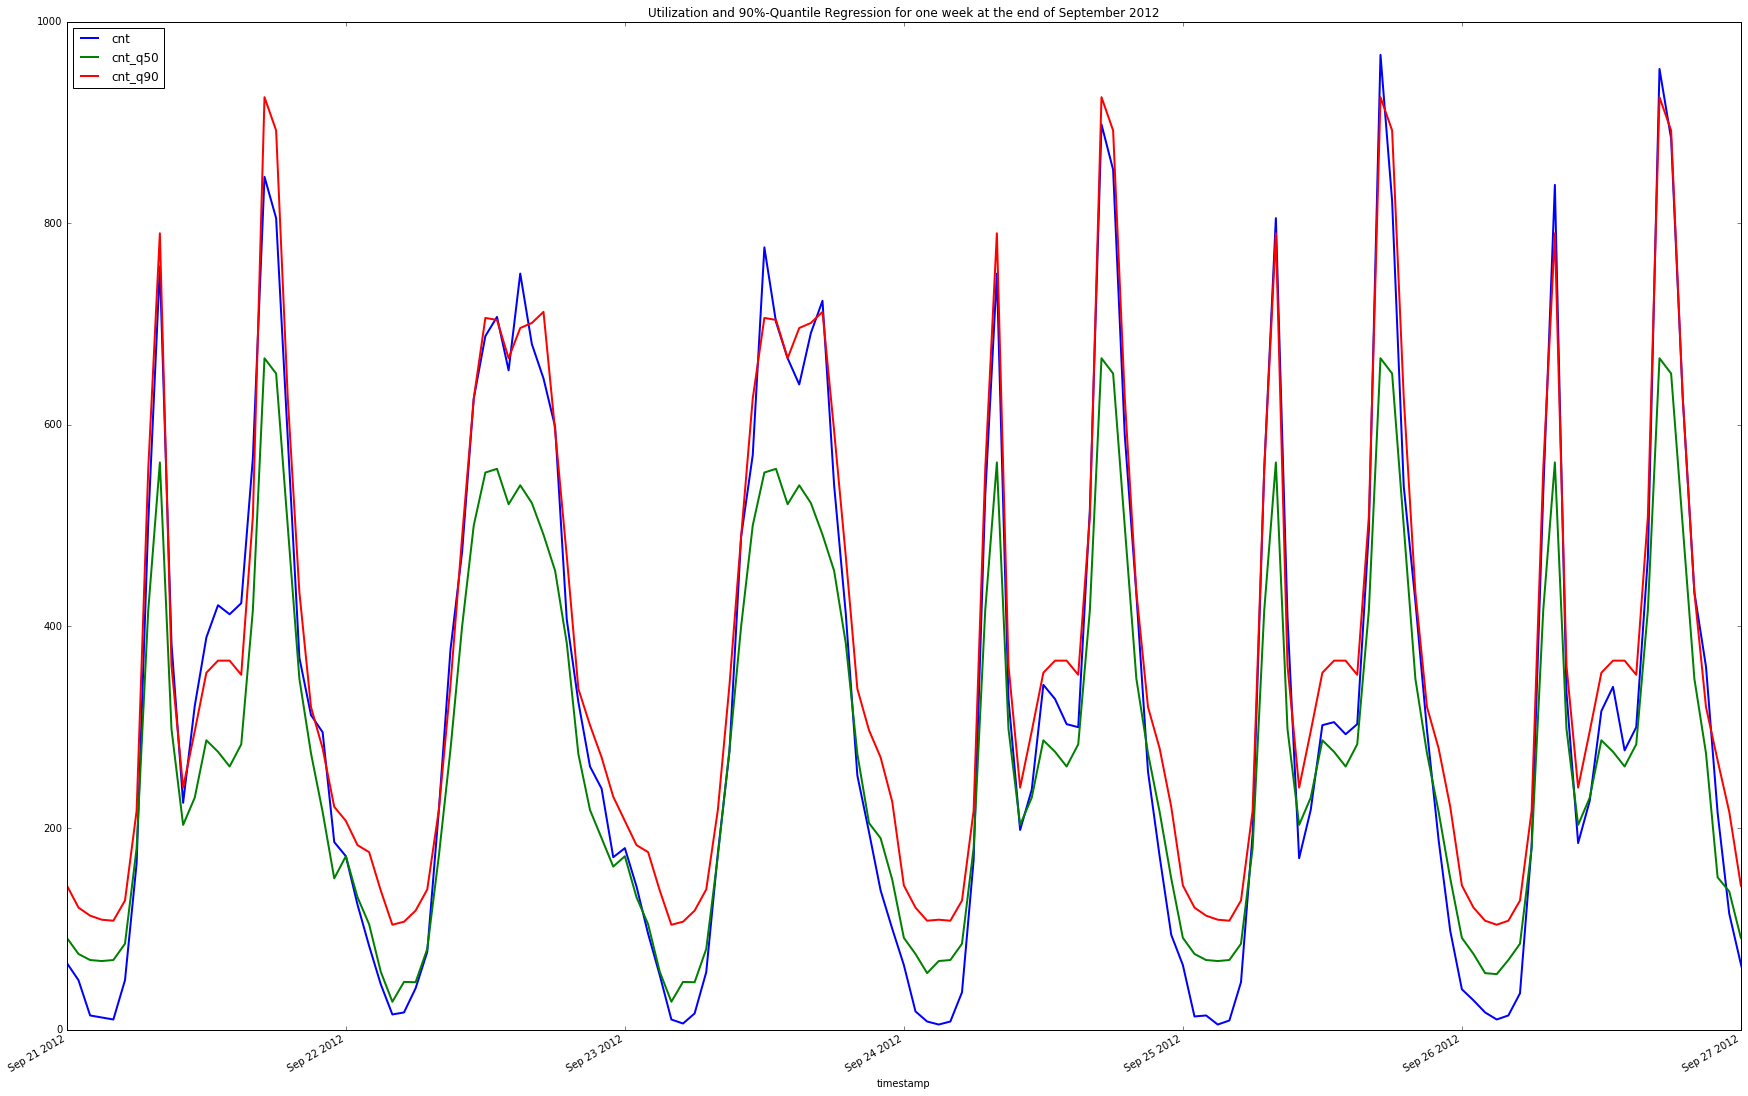

In [26]:
count_by_hour = hour[['timestamp','cnt','cnt_q50','cnt_q90']].set_index('timestamp')

plt.figure( )
count_by_hour.plot(figsize=(30,20), linewidth=2)
plt.xlim(datetime.date(2012, 9, 21), datetime.date(2012, 9, 27))
plt.ylim(0,1000)
plt.title("Utilization and 90%-Quantile Regression for one week at the end of September 2012")

plt.legend(loc='best')
plt.show()

With a desired level of confidence of 90% the predictions would have guaranteed a high level of availability to the customer. End of September 2012 turned out to be a time with the highest hourly utilization.
At this point managers can evaluate their maintenance processes and adapt to high the demand and hence sustain availability even at most critical times of the year.

The mean absolute deviations of the utilization predicted by the linear models form the observed values are:

In [27]:
print("mean absolute deviance for q50:" , hour['abs_dev_q50'].mean() , "for q90: ", hour['abs_dev_q90'].mean(), "and for OLS:", hour['abs_dev_OLS'].mean() )

mean absolute deviance for q50: 48.68053411650068 for q90:  79.64946908131675 and for OLS: 51.09465833840732


The mean absolute deviation tells us that the error of estimation is around 50 bikes  each hour. In the case of the 90%-quantile regression it utilization is mostly overestimated by around 80 bikes per hour. In relation to almost 1000 bikes per hour as a maximum we have a relative mean absolut deviation of approximately 5% with the linear model.